# Image Segmentation

The main objectives of this module are:

* Use & compare different methods of segmentation:
    * Histogram-based
    * Texture-based
    * Region growing
* Detect objects and extract object features.
* Understand corner detection and basic object recognition

## 1. Histogram segmentation

In histogram segmentation, we make the hypothesis that the histogram is composed of distinct separable distributions, and we try to find the best threshold to separate those distributions.

The code below uses a default threshold of 127 to segment the image. Modify it to:

1. Create a function to compute the optimal threshold for an 8 bit image. Apply on the cameraman image.
1. Compute the Otsu threshold for an 8-bit image, by optimizing within variance or inter-class variance for each possible theshold *t*. See [here](http://nbviewer.jupyter.org/github/odebeir/info-h-500-501/blob/ver_2016-2017/04-Image%20segmentation/01-Histogram%20based%20image%20segmentation.ipynb) how to compute the Otsu threshold.

In [88]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from skimage.io import imread, imshow


def manual_threshold(im, T):
    return im>T

def optimal_threshold(h, T0): # T0 is the initial threshold
    # Cut the distribution
    G1 = h[:T0]
    G2 = h[T0:]

    # Compute the centroids
    m1 = (G1*np.arange(0, T0)).sum()/G1.sum()
    m2 = (G2*np.arange(T0, len(h))).sum()/G2.sum()

    # Compute the new threshold
    T1 = int(np.round((m1+m2)/2))
    
    if(T1 != T0):
        return optimal_threshold(h, T1)
    
    return T1
    
def otsu_threshold(h):
    p = h*1./h.sum() # Probability histogram

    var_within = np.zeros(len(h))
    var_between = np.zeros(len(h))
    sep = np.zeros(len(h))
    
    for t in range(1, len(h)-1):
        # Class probabilities
        w0 = p[:t].sum()
        w1 = p[t:].sum()
        # Class centroids
        m0 = (np.arange(0,t)*p[:t]).sum()/w0
        m1 = (np.arange(t,len(h))*p[t:]).sum()/w1
        # Class variances
        s0 = (((np.arange(0,t)-m0)**2)*p[:t]).sum()/w0
        s1 = (((np.arange(t,len(h))-m1)**2)*p[t:]).sum()/w1
        # Intra-class variance
        sw = w0*s0+w1*s1
        # Inter-class variance
        sb = w0*w1*((m1-m0)**2)
        # Separability (needs to be maximized)
        l = sb/sw
        var_within[t] = sw
        var_between[t] = sb
        sep[t] = l
    best_t = np.argmax(sep)

    return best_t, var_within, var_between, sep

In [89]:
def plot_histogram_with_threshold(im, T):
    plt.figure(figsize=(15,5))
    h = plt.hist(im.flatten(), bins=range(256))
    plt.plot([T,T],[0,h[0].max()], 'r-')
    plt.show()

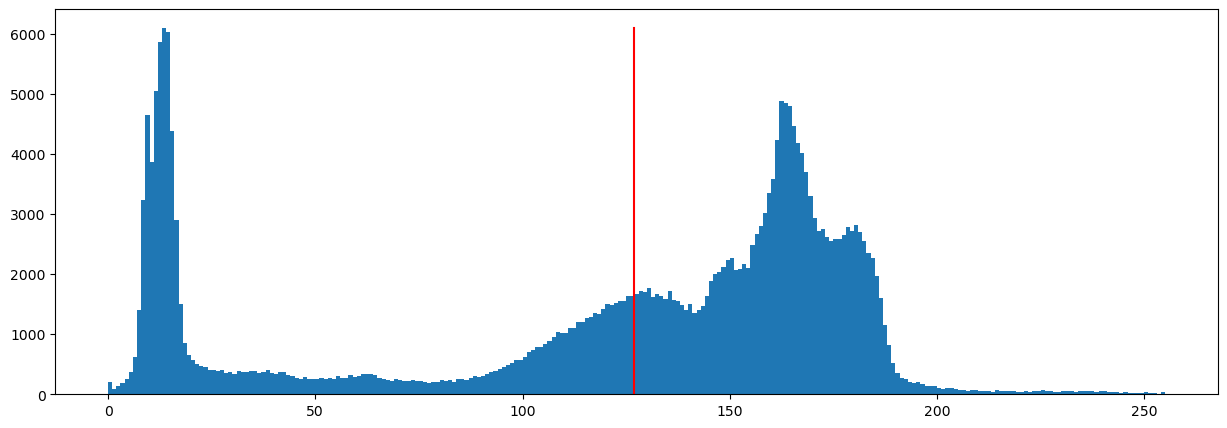

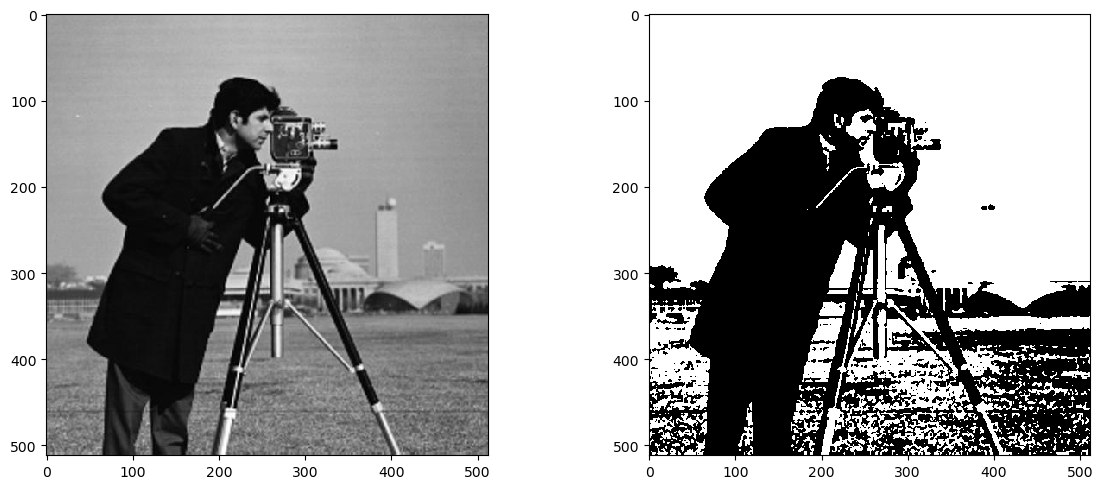

In [90]:
im = imread('camera.jpg')

T = 127 # every pixel with intensity > T will be set to 1, otherwise 0
im_segmented = manual_threshold(im, T)

plot_histogram_with_threshold(im, T)

# Show original image & segmented binary image
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
imshow(im)
plt.subplot(1,2,2)
imshow(im_segmented)
plt.show()

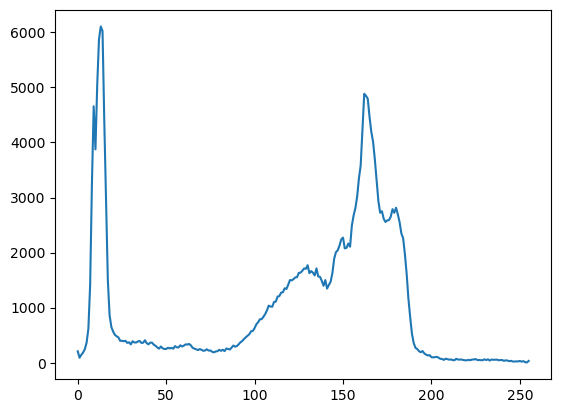

Optimal threshold : 88


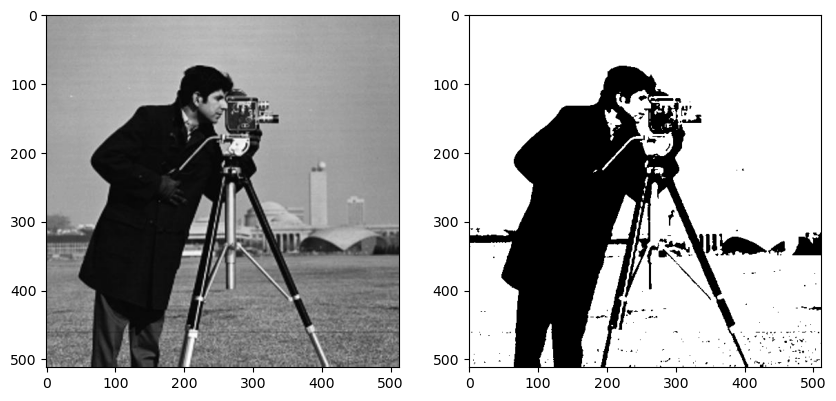

In [91]:
# Let's automate the threshold selection
# Optimal thresholding
h,bins = np.histogram(im,range(257))

plt.figure()
plt.plot(h)
plt.show()

t = optimal_threshold(h,128)
print("Optimal threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im>t, cmap=plt.cm.gray)
plt.show()


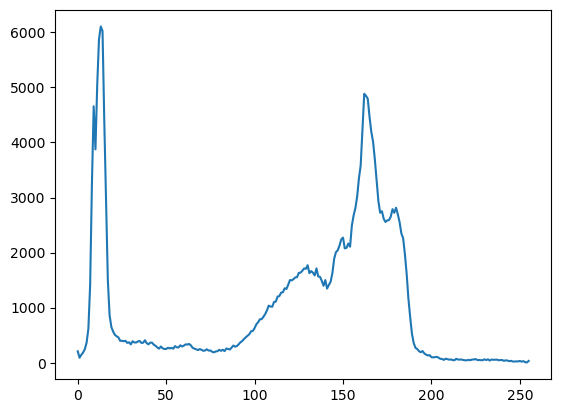

Optimal threshold : 88


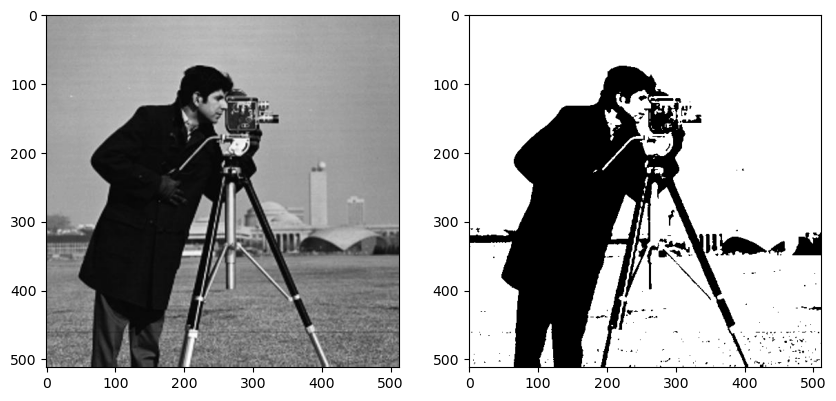

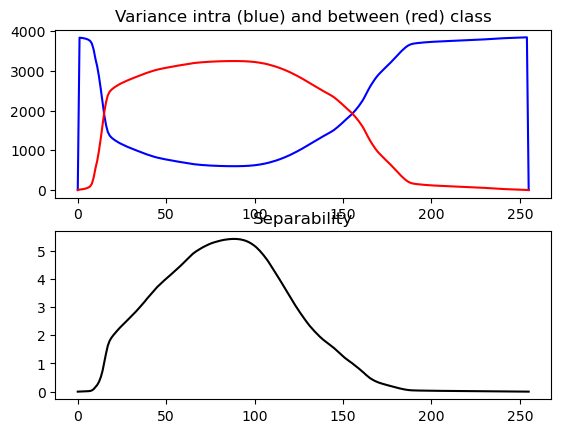

In [92]:
# Otsu thresholding
plt.figure()
plt.plot(h)
plt.show()

t,vw,vb,sep = otsu_threshold(h)
print("Optimal threshold : %d"%t)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.subplot(1,2,2)
plt.imshow(im>t, cmap=plt.cm.gray)
plt.show()
plt.figure()
plt.subplot(2,1,1)
plt.plot(vw, 'b-')
plt.plot(vb, 'r-')
plt.title('Variance intra (blue) and between (red) class')
plt.subplot(2,1,2)
plt.plot(sep, 'k-')
plt.title('Separability')
plt.show()



**Need more help? You can check the following videos:**

* [Manual thresholding](https://www.youtube.com/watch?v=rgKkws_fqz4&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=24)
* [Optimal threshold](https://www.youtube.com/watch?v=7B1cs0PARtg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=25)
* [Otsu threshold](https://www.youtube.com/watch?v=mz26bssSLds&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=26)

## 2. Texture segmentation

Texture segmentation uses regional descriptors to segment the image based on the local texture. A simple algorithm is provided below, which:

* Extract neighborhoods with the sliding window method
* Compute the local maximum on the neighborhood and put it in a "descriptor" image
* Use Otsu thresholding on the descriptor image to segment it
* Display the results

/home/onyx/anaconda3/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:149: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


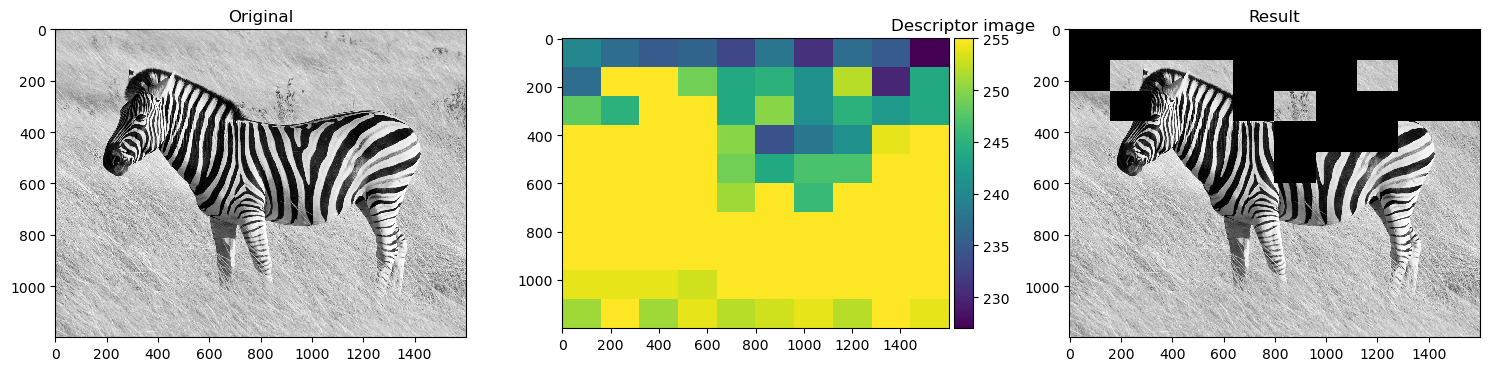

In [93]:
from skimage.filters.rank import entropy
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

def texture_descriptor(N):
    e = N.max() # Replace with your descriptor
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

# Open zebra image as an 8-bit integer grayscale
im = img_as_ubyte(imread("zebra.jpg", as_gray=True))

im_descr = sliding_window(im,(120,160))
T = threshold_otsu(im_descr)
mask = im_descr>T

plt.figure(figsize=(15,8))
plt.subplot(1,3,1)
imshow(im)
plt.title('Original')
plt.subplot(1,3,2)
imshow(im_descr)
plt.title('Descriptor image')
plt.subplot(1,3,3)
imshow(im*mask)
plt.title('Result')
plt.show()

Using the above example as a starting point, replace the "maximum" texture descriptor by properties from the co-occurrence matrix:
* Compute the co-occurrence matrix on the neighborhood (see [greycomatrix](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycomatrix)). Test different angles & displacements.
* Test different properties (see [greycoprops](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.greycoprops))

Try to segment the zebra image as best as you can using those descriptors.

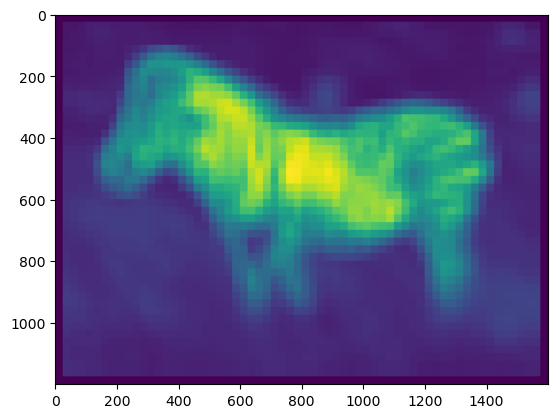

In [94]:
from skimage.feature import graycomatrix, graycoprops

def texture_descriptor(N):
    displacement = 25
    angles = [0, np.pi/6, np.pi/4, np.pi/3]
    glcm = graycomatrix(N, [displacement], angles, 256)
    return graycoprops(glcm, 'dissimilarity').max()

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

def sliding_window_overlap(im, PATCH_SIZE, STRIDE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, STRIDE):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, STRIDE):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            c = (i+PATCH_SIZE[0]//2, j+PATCH_SIZE[1]//2) # center of the patch
            output[c[0]-STRIDE:c[0]+STRIDE, c[1]-STRIDE:c[1]+STRIDE] = texture_descriptor(patch)
    return output


output = sliding_window_overlap(im, (100,100), 25)

plt.figure()
plt.imshow(output)
plt.show()

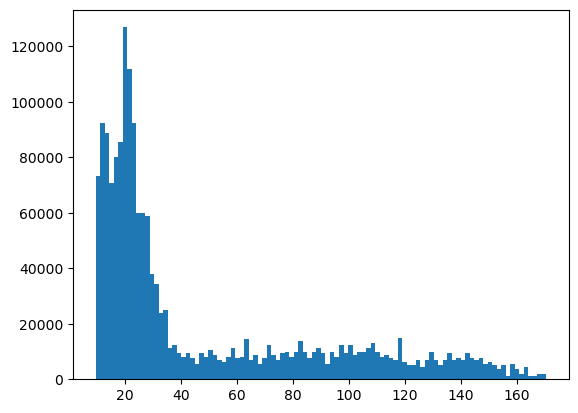

In [95]:
plt.figure()
plt.hist(output[output>0].flatten(), bins=100)
plt.show()

Best threshold: 68.30


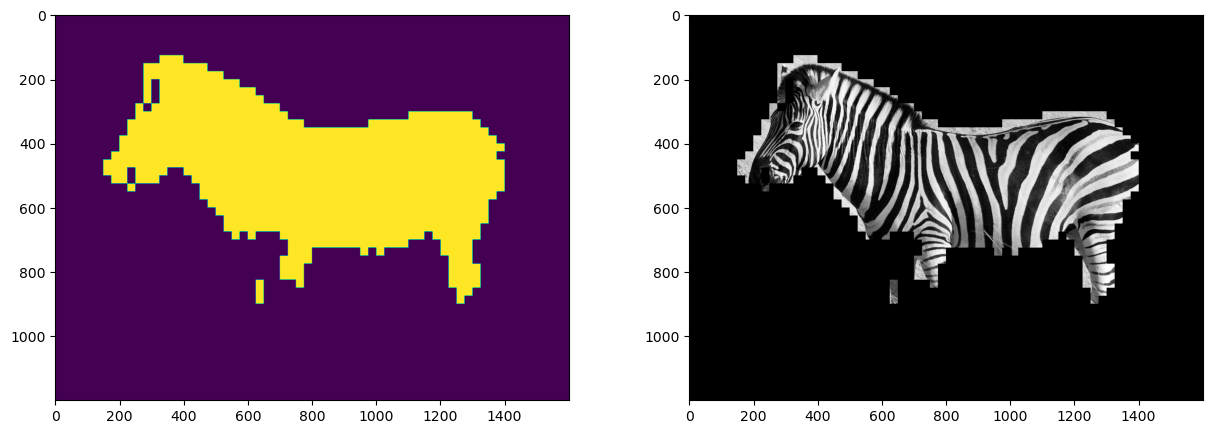

In [96]:
h,bins = np.histogram(output[output>0],bins=100)
t,_,_,_ = otsu_threshold(h)

# t gives the index of the "bin" that was selected as the best threshold. If we want the actual threshold value, 
# we need to take the "center" of the bin:
t = (bins[t]+bins[t+1])/2
mask = output>t

print("Best threshold: %.2f"%t)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(output>t)
plt.subplot(1,2,2)
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

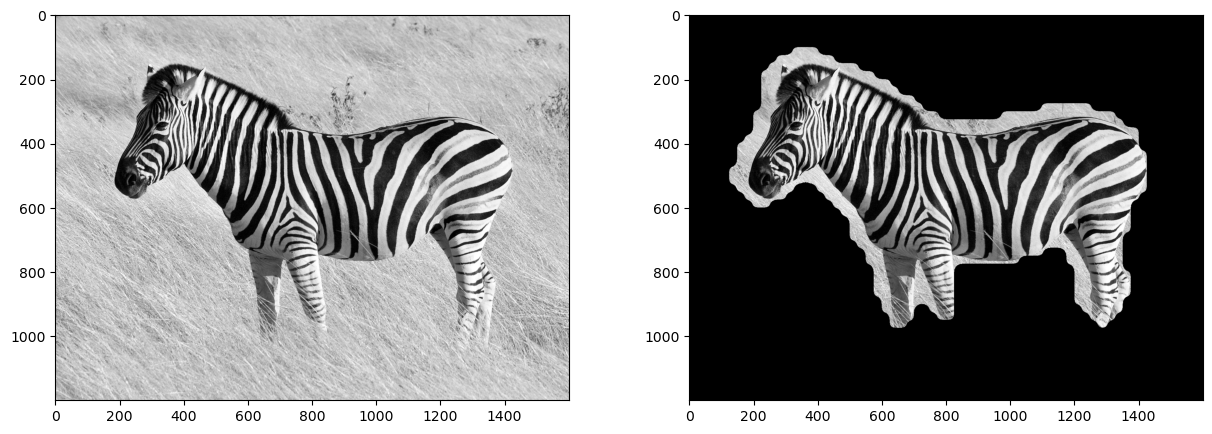

In [97]:
from skimage.morphology import disk, opening, closing

mask = opening(closing(output>40, disk(25)), disk(15))
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(im, cmap=plt.cm.gray)
plt.subplot(1,2,2)
plt.imshow(im*mask, cmap=plt.cm.gray)
plt.show()

**Need more help? You can check the following videos:**

* [Region descriptors](https://www.youtube.com/watch?v=5F9aPiab8PA&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=27)
* [Properties of the co-occurrence matrix](https://www.youtube.com/watch?v=NR3vrkZ9tyg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=28)
* [Texture segmentation](https://www.youtube.com/watch?v=b-SGhLu-R0c&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=29)

## 3. Region growing

In region growing algorithms, we start from "markers" which act as seed points, and grow the segmented regions from those markers. A well-known region-growing algorithm uses the watershed transform. The example below uses the watershed transform on the cameraman image, with hand-picked markers:

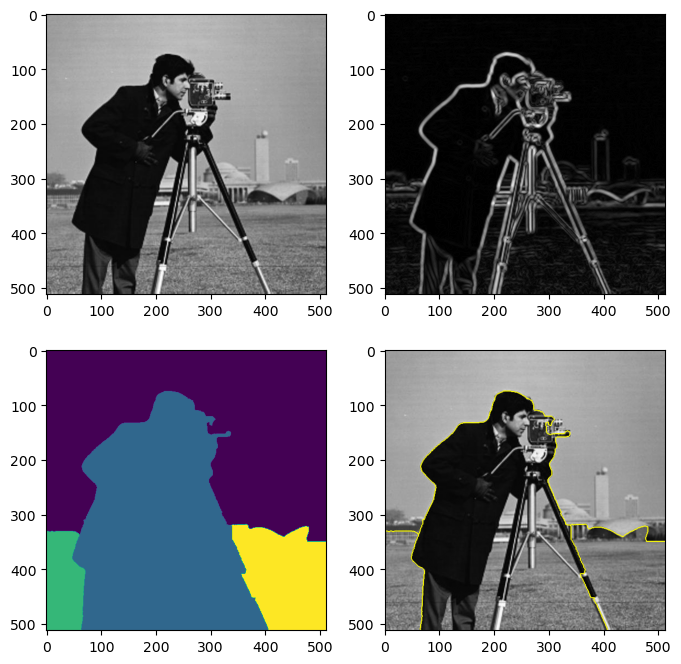

In [98]:
from skimage.morphology import disk
import skimage.filters.rank as skr
from skimage.segmentation import mark_boundaries, watershed
from skimage.io import imread

im = imread('camera.jpg')

smoothing_factor = 4
# Compute the gradients of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))

# Hand-picked markers for the road image
markers_coordinates = [
    [10,256], # sky
    [200,150],# cameraman
    [400,20], # grass (left)
    [400,450] # grass (right)
]

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

plt.figure(figsize=[8,8])
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray)
plt.subplot(2,2,2)
plt.imshow(gradient,cmap=plt.cm.gray)
plt.subplot(2,2,3)
plt.imshow(ws)
plt.subplot(2,2,4)
plt.imshow(mark_boundaries(im,ws))

Adapt this method to work on the road image.

Can you find a way to automatically determine the markers?

/tmp/ipykernel_589947/1529672224.py:13: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  im_ = gaussian(im,2)
/tmp/ipykernel_589947/1529672224.py:21: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  markers_coordinates, grad = get_markers(im)


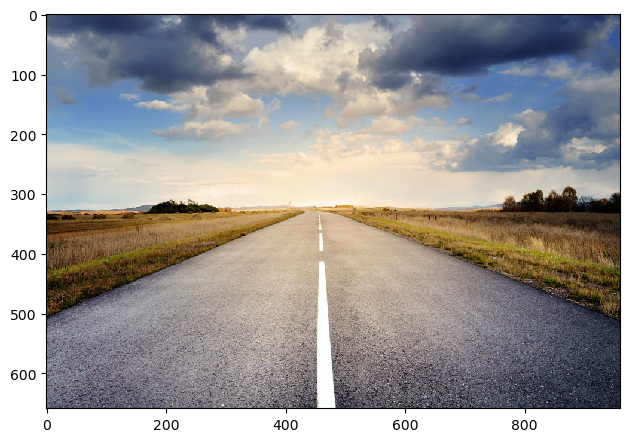

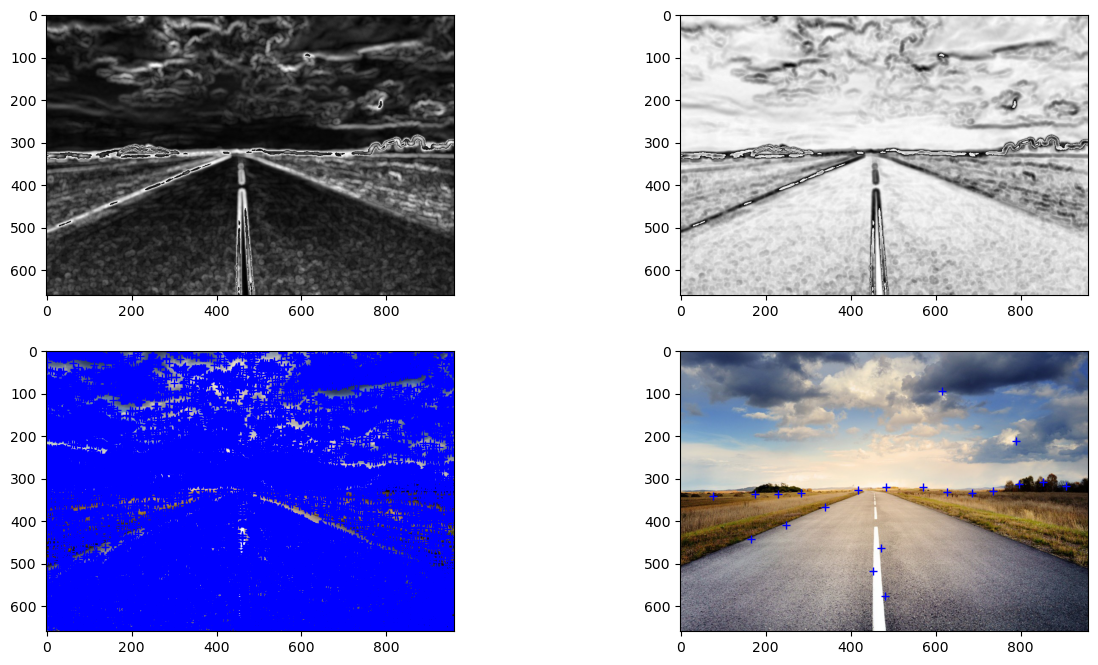

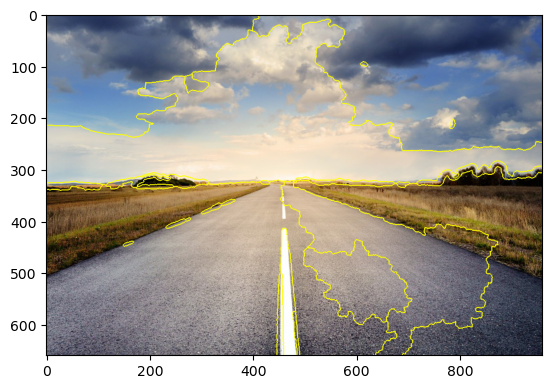

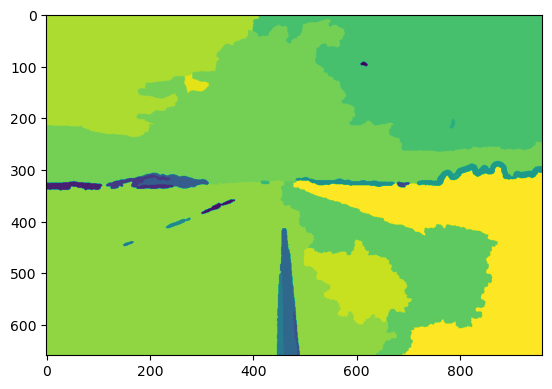

In [99]:
from skimage.filters import sobel,gaussian
from skimage.feature import peak_local_max
import skimage.filters.rank as skr
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label

im = imread('road.jpg')

imshow(im)

def get_markers(im):
    im_ = gaussian(im,2)
    gradr = skr.gradient(im_[:,:,0], disk(5).astype('int'))
    gradg = skr.gradient(im_[:,:,1], disk(5).astype('int'))
    gradb = skr.gradient(im_[:,:,2], disk(5).astype('int'))
    grad = gradr+gradg+gradb

    return peak_local_max(grad.max()-grad,threshold_rel=0.5, min_distance=60),grad

markers_coordinates, grad = get_markers(im)

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

# markers = label(markers)
ws = watershed(grad, markers[:,:,0])

def show():
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    plt.imshow(grad, cmap=plt.cm.gray)
    plt.subplot(2,2,2)
    plt.imshow(grad.max()-grad, cmap=plt.cm.gray)
    plt.subplot(2,2,3)
    plt.imshow(im)
    markers = peak_local_max(grad.max()-grad)
    plt.plot(markers[:,1],markers[:,0],'b+')
    plt.subplot(2,2,4)
    plt.imshow(im)
    markers = peak_local_max(grad.max()-grad, threshold_rel=0.99, min_distance=50)
    plt.plot(markers[:,1],markers[:,0],'b+')
    plt.show()

    plt.figure()
    plt.imshow(mark_boundaries(im,ws))
    plt.figure()
    plt.imshow(ws)
    plt.show()

show()


/tmp/ipykernel_589947/2785789685.py:11: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  im_ = gaussian(im, sigma=2)
/tmp/ipykernel_589947/2785789685.py:19: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  grad = get_grad(im)


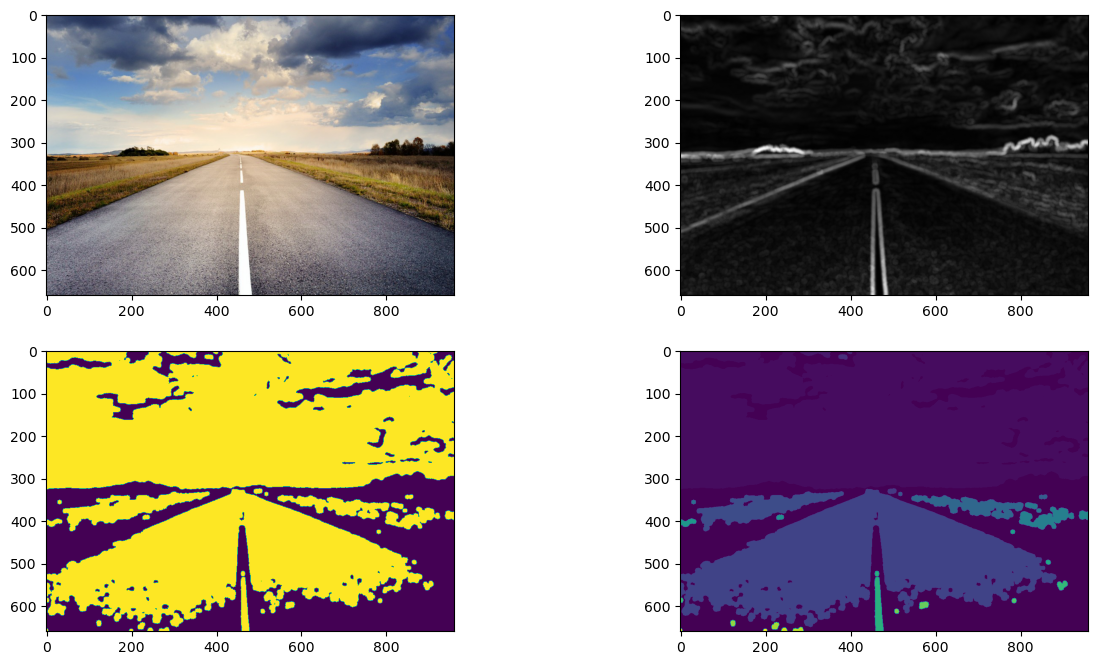

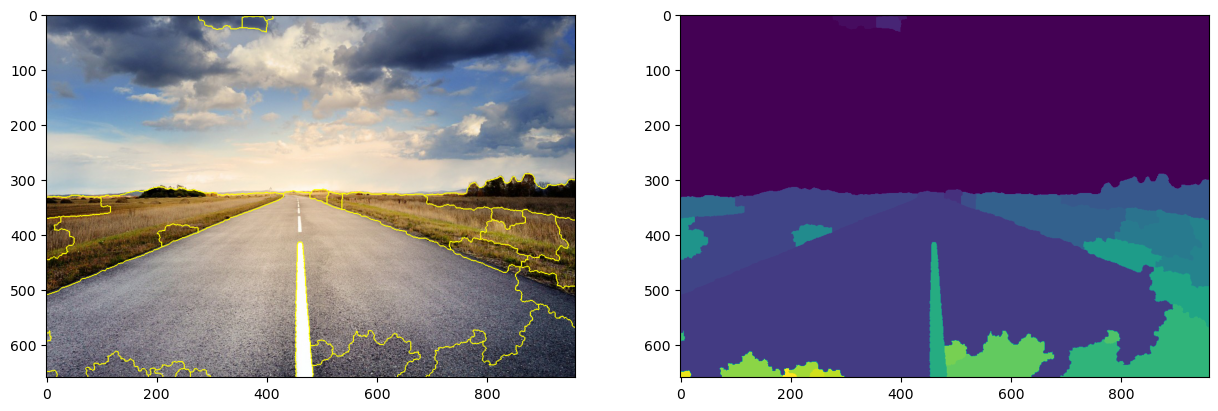

In [100]:
from skimage.filters import sobel,gaussian
from skimage.feature import peak_local_max
import skimage.filters.rank as skr
from skimage.segmentation import watershed
from skimage.segmentation import mark_boundaries
from skimage.measure import label

im = imread('road.jpg')

def get_grad(im):
    im_ = gaussian(im, sigma=2)
    gradr = skr.gradient(im_[:,:,0],disk(5)).astype('int')
    gradg = skr.gradient(im_[:,:,1],disk(5)).astype('int')
    gradb = skr.gradient(im_[:,:,2],disk(5)).astype('int')
    grad = gradr+gradg+gradb

    return grad

grad = get_grad(im)
markers = skr.minimum(im[:,:,0], disk(5)) >= grad
markers = opening(markers, disk(5))
lab = label(markers, background=0)

# markers = label(markers)
ws = watershed(grad, lab)

def show():
    plt.figure(figsize=(15,8))
    plt.subplot(2,2,1)
    plt.imshow(im, cmap=plt.cm.gray)
    plt.subplot(2,2,2)
    plt.imshow(grad, cmap=plt.cm.gray)
    plt.subplot(2,2,3)
    plt.imshow(markers)
    plt.subplot(2,2,4)
    plt.imshow(lab)
    plt.show()

    plt.figure(figsize=[15,8])
    plt.subplot(1,2,1)
    plt.imshow(mark_boundaries(im,ws))
    plt.subplot(1,2,2)
    plt.imshow(ws)
    plt.show()

show()

Another use of the watershed transform is to separate overlapping object, as in the image below.

* Compute the [distance transform](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html#scipy.ndimage.distance_transform_edt) of the image.
* Use the result to automatically find good markers.
* Use the watershed transform to separate the three objects.

49.040799340956916


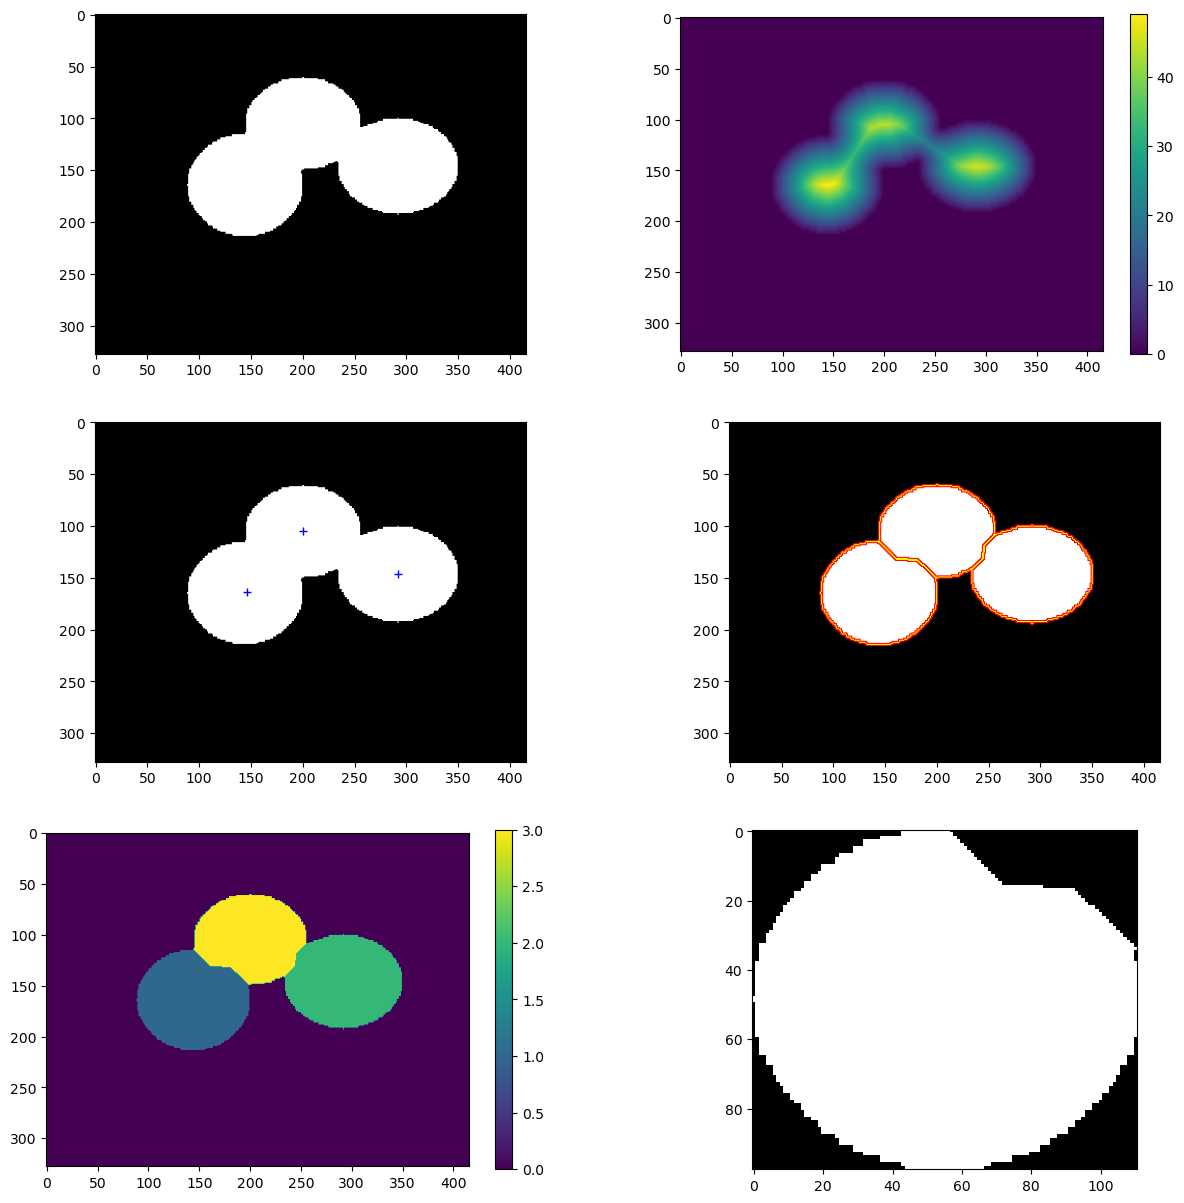

In [101]:
from scipy.ndimage import distance_transform_edt
from skimage.color import rgb2gray
from skimage.measure import label, regionprops

im = (rgb2gray(imread('separ.png'))==0).astype('uint8')
im[im == 1] = 255

distance = distance_transform_edt(im)
markers_coordinates = peak_local_max(distance, min_distance=3)

print(distance.max())

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(255-distance, markers, mask=(im>1))

def show():
    plt.figure(figsize=[15,15])
    plt.subplot(3,2,1)
    plt.imshow(im,cmap=plt.cm.gray)
    plt.subplot(3,2,2)
    plt.imshow(distance)
    plt.colorbar()
    plt.subplot(3,2,3)
    for marker in markers_coordinates:
        plt.plot(marker[1],marker[0],'b+')
    plt.imshow(im,cmap=plt.cm.gray)
    plt.subplot(3,2,4)
    plt.imshow(mark_boundaries(im, ws, outline_color=[1,0,0]))
    plt.subplot(3,2,5)
    plt.imshow(ws)
    plt.colorbar()
    plt.subplot(3,2,6)
    plt.imshow(regionprops(ws)[0].image, cmap=plt.cm.gray)
    plt.show()

show()


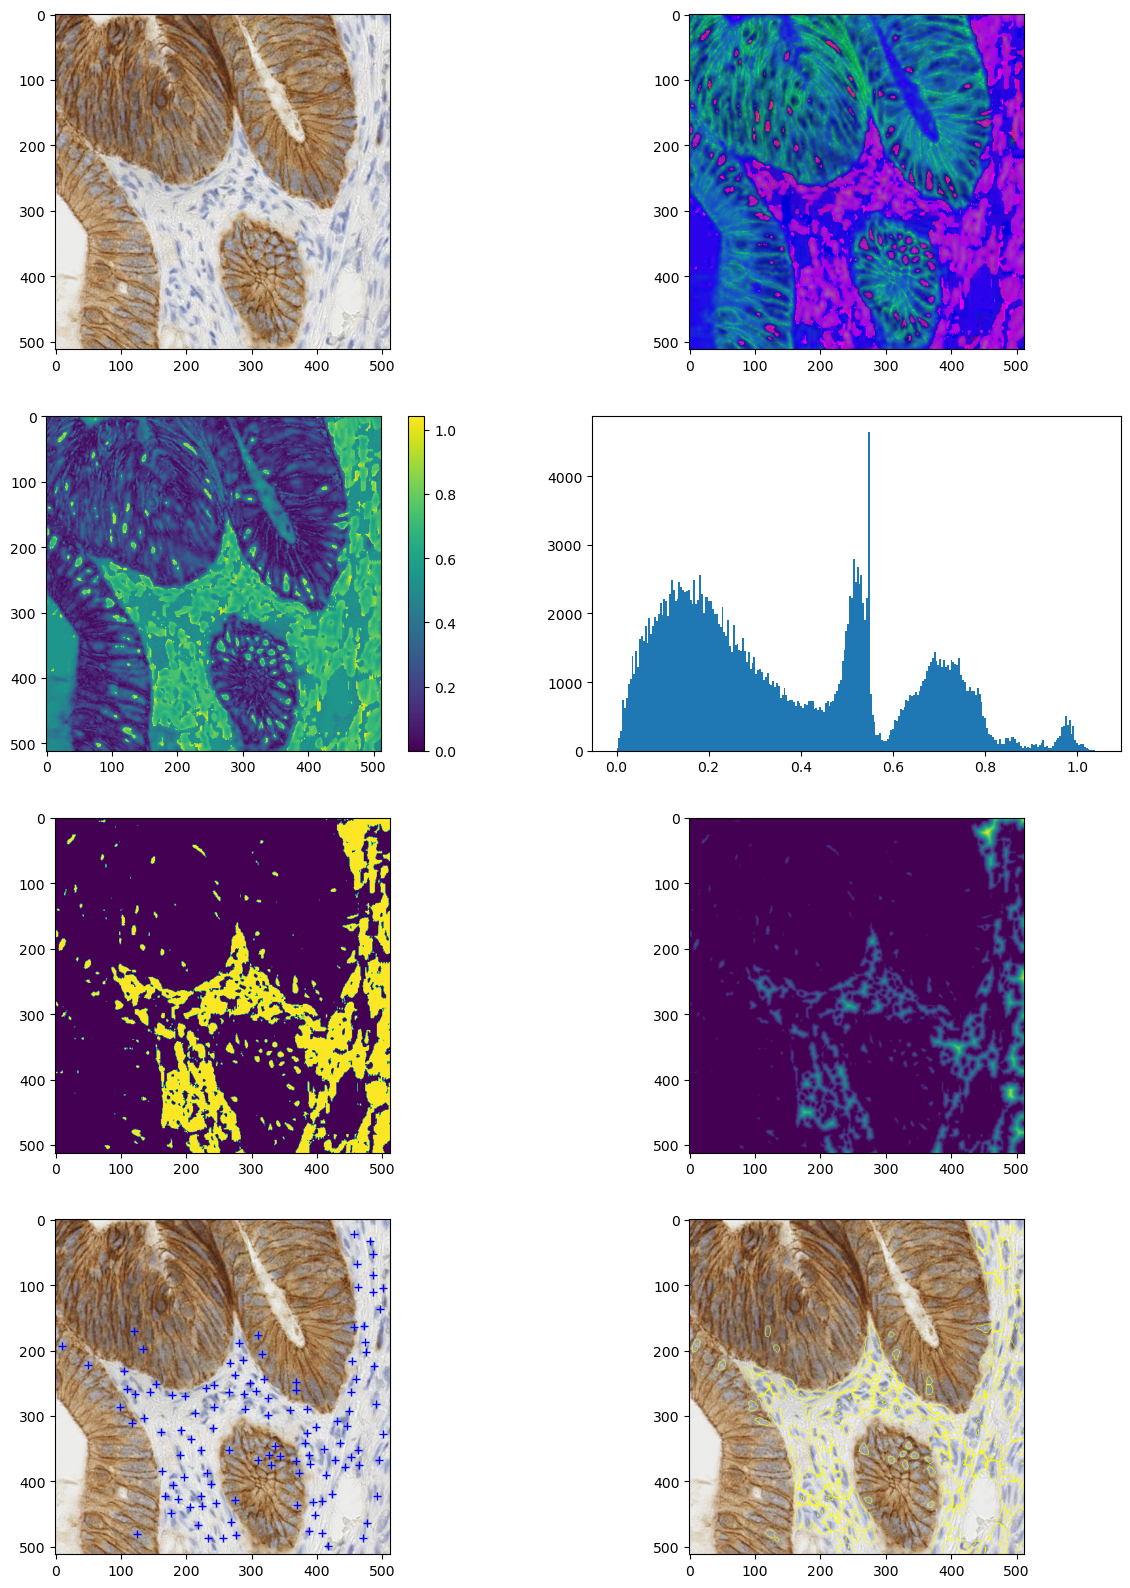

In [102]:
from skimage.data import immunohistochemistry
from skimage.color import rgb2hsv

def distance_color_map(image, coords):
    refcolor = image[coords[0], coords[1]]
    dmap = np.sqrt(((image-refcolor)**2).sum(axis=2))
    return dmap

im = immunohistochemistry()
hsv = rgb2hsv(im)

dmap = distance_color_map(hsv, (10,350))
mask = dmap>0.6
# mask = opening(closing(dmap>0.6, disk(2)),disk(2))
distance = distance_transform_edt(mask)

markers_coordinates = peak_local_max(distance, min_distance=10, threshold_rel=0.2)

markers = np.zeros_like(dmap)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(dmap, markers, mask=mask)

def show():
    plt.figure(figsize=[15,20])
    plt.subplot(4,2,1)
    plt.imshow(im)
    plt.subplot(4,2,2)
    plt.imshow(hsv)
    plt.subplot(4,2,3)
    plt.imshow(dmap)
    plt.colorbar()
    plt.subplot(4,2,4)
    plt.hist(dmap.flatten(), bins=256)
    plt.subplot(4,2,5)
    plt.imshow(dmap>0.6)
    plt.subplot(4,2,6)
    plt.imshow(distance)
    plt.subplot(4,2,7)
    for marker in markers_coordinates:
        plt.plot(marker[1],marker[0],'b+')
    plt.imshow(im,cmap=plt.cm.gray)
    plt.subplot(4,2,8)
    plt.imshow(mark_boundaries(im, ws))
    plt.show()

show()

**Need more help? You can check the following videos:**

* [Markers for region growing](https://www.youtube.com/watch?v=3e0-rE9zhFk&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=30)
* [Watershed transform](https://www.youtube.com/watch?v=GuVp7dlzEKE&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=31)
* [Distance transform](https://www.youtube.com/watch?v=s1eABOdNnVg&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=32)

## 4. Object features

The next step after segmentation is often to extract object features in order to recognize, classify, or measure information about the objects.

Starting from the example below:

1. **Extract connected components** (see [label()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=label#skimage.measure.label)) of the shapes image and **display the centroid of the objects** (see [regionprops()](http://scikit-image.org/docs/dev/api/skimage.measure.html?highlight=regionprops#skimage.measure.regionprops))
1. For each image label, **extract the coordinates of the contour** (see [find_contours()](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.find_contours)) and **find the corners** of each objects.
1. Suggest a method to **classify the objects** in different categories.

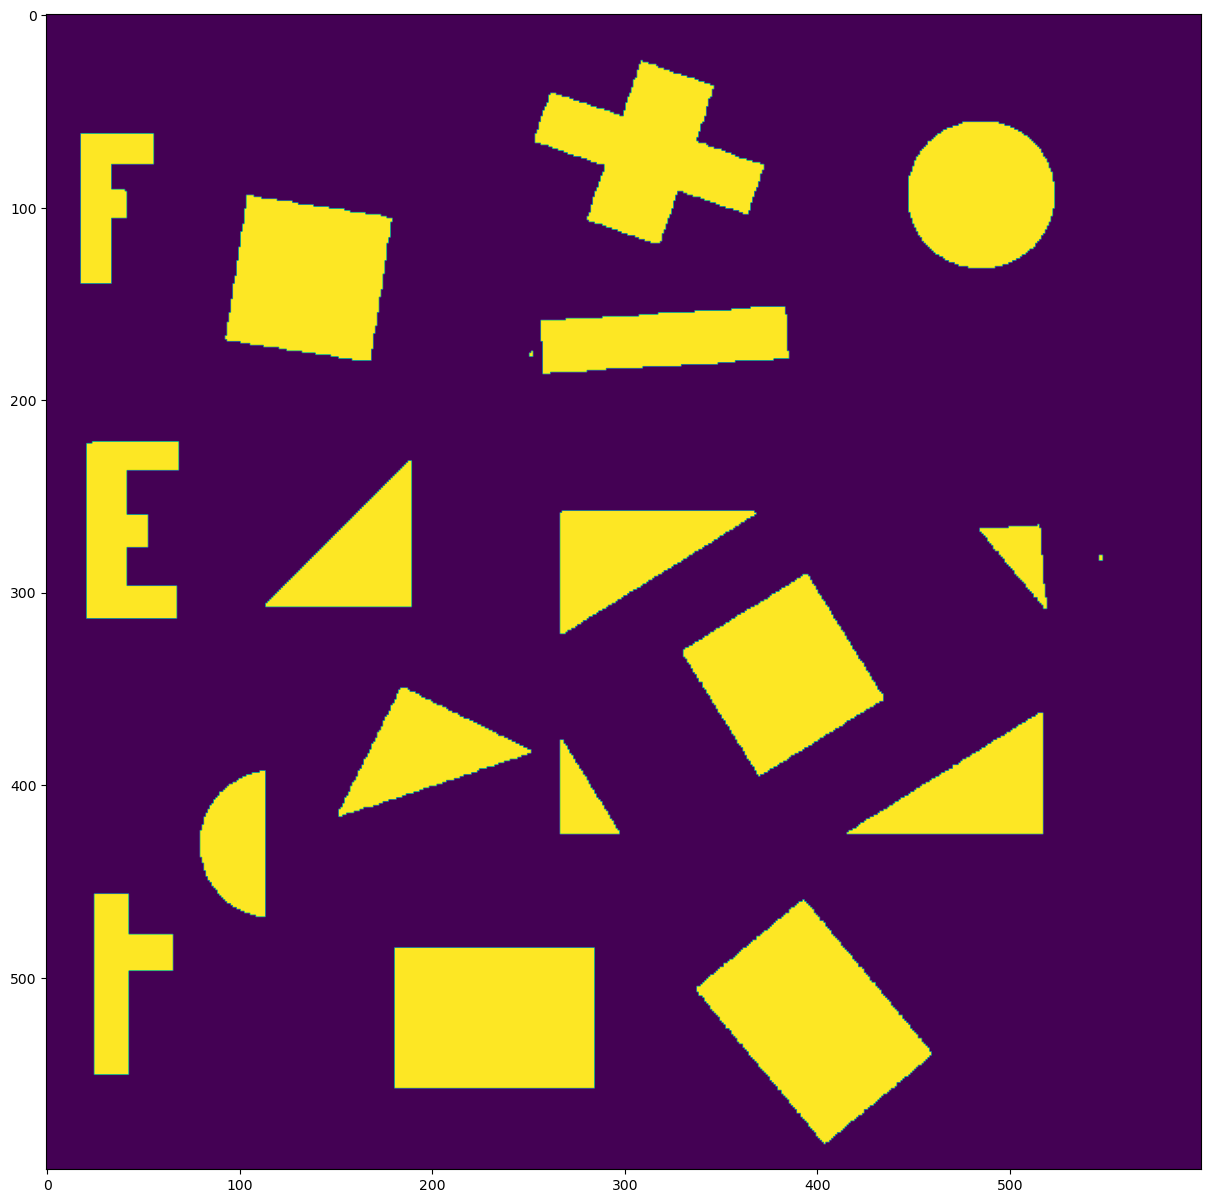

In [103]:
from skimage.measure import label, regionprops,find_contours

im = (imread('shapes.png')[:,:,0]>0).astype(int) #binarize & cast to integer to make it easier to process later

plt.figure(figsize=(15,15))
plt.imshow(im)
plt.show()

Number of elements : 17


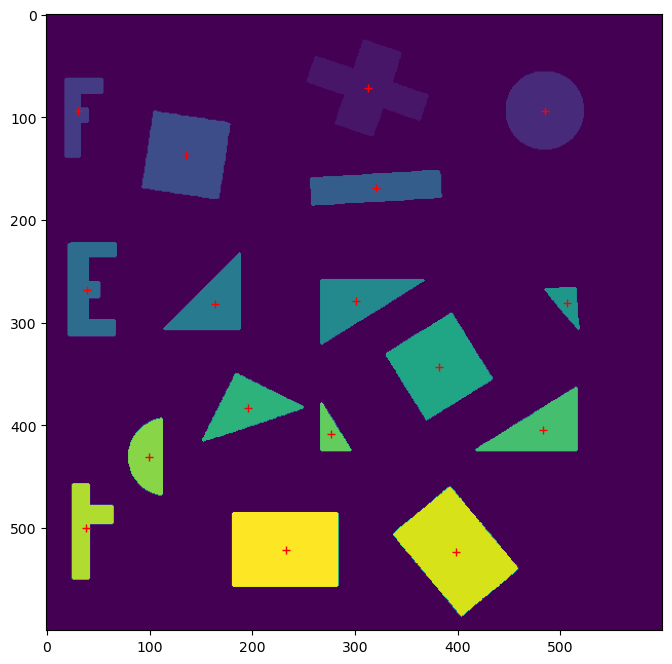

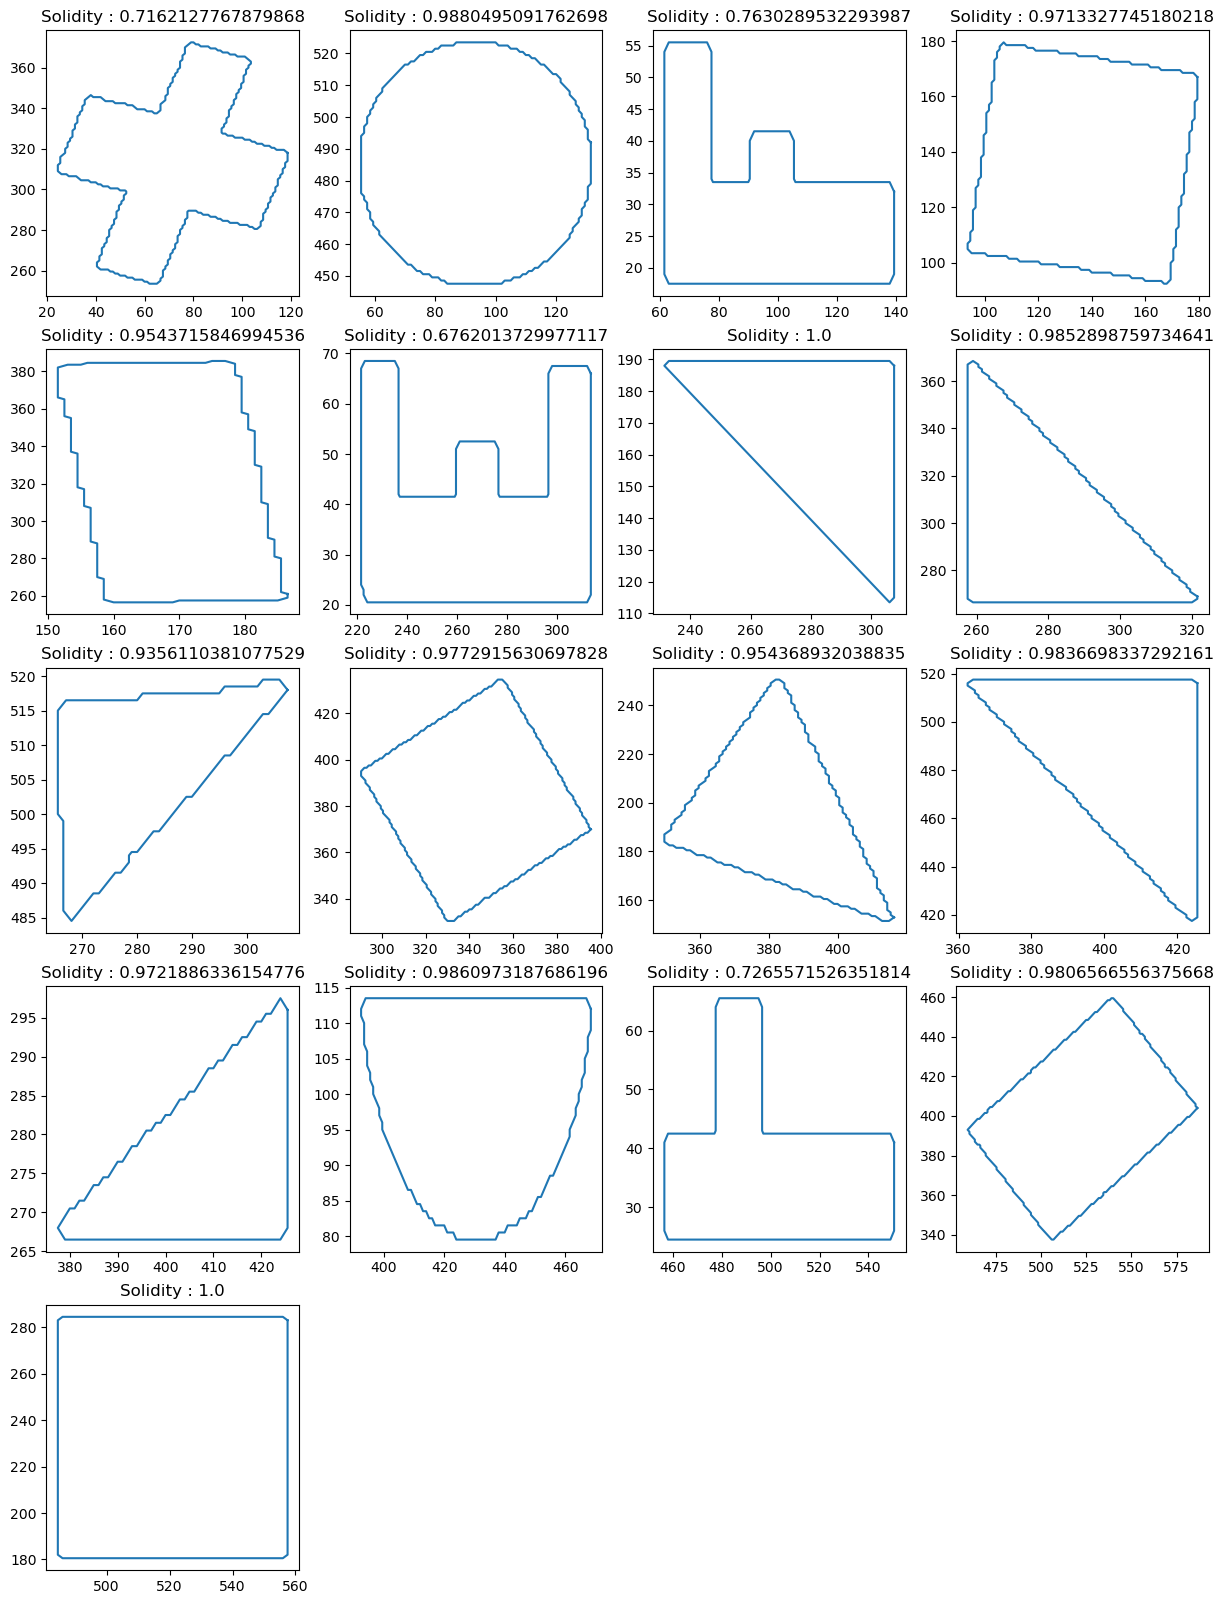

In [104]:
im = (imread('shapes.png')[:,:,0]>0).astype(int)
im = opening(im)

lab = label(im,background=0)
props = regionprops(lab)
print("Number of elements :", len(props))

# props informations :
#   - image (cropped image of the region)
#   - centroid (center of the region)
#   - solidity (ratio of pixels in the region to pixels of the convex hull image.)
#   - area (area ofthe region)

plt.figure(figsize=[8,8])
plt.imshow(lab)
for elem in props:
    centroid = elem.centroid
    plt.plot(centroid[1], centroid[0], 'r+')
plt.show()

contours = find_contours(im)

plt.figure(figsize=[15,20])
for i in range(len(contours)):
    contour = contours[i].copy()
    plt.subplot(5,4,i+1)
    plt.plot(contour[:, 0], contour[:, 1])
    plt.title(f"Solidity : {props[i].solidity}")
plt.show()

**Need more help? You can check the following videos:**

* [Object labeling & features](https://www.youtube.com/watch?v=7bOH4E7c8gU&list=PLI3XOM9BWLSW6vTPxc9ZfSABS31o7HMub&index=33)

# Coding project - Tumour segmentation

The image below is a slice of a brain MRI with a large tumour in it. The goal of this project is to create an algorithm to automatically segment the tumour.

Given that the resolution of the image is of 0.115 cm/px in both axis, estimate the area of the tumour (in cm²). 

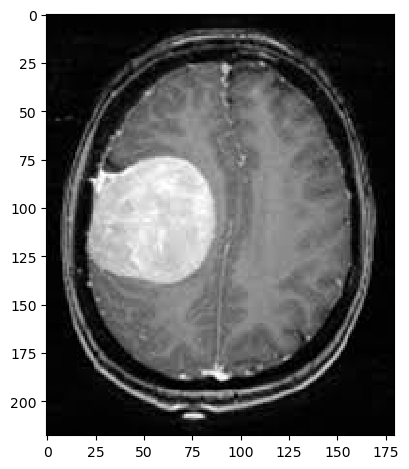

In [105]:
from skimage.io import imread,imshow
%matplotlib inline

im = imread('mri_brain.jpg')
imshow(im)

In [106]:
from skimage.morphology import disk, rectangle, opening
from skimage.filters.edges import sobel
import skimage.filters.rank as skr
from skimage.filters import threshold_otsu
from skimage import img_as_ubyte

def compute_tumor_size(image):
    sum = 0
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            if image[x,y] != 0:
                sum += 1

    print("area of the tumor : " + str(0.115**2 * sum) + " cm2")

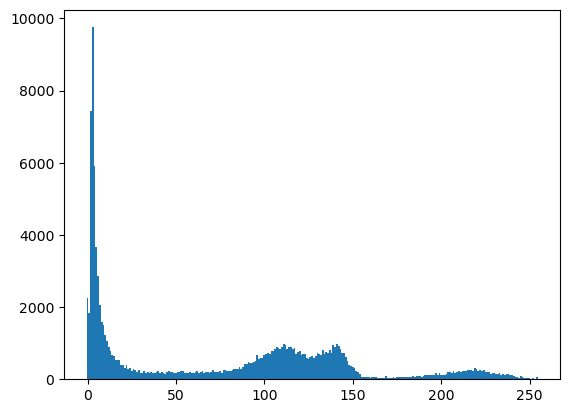

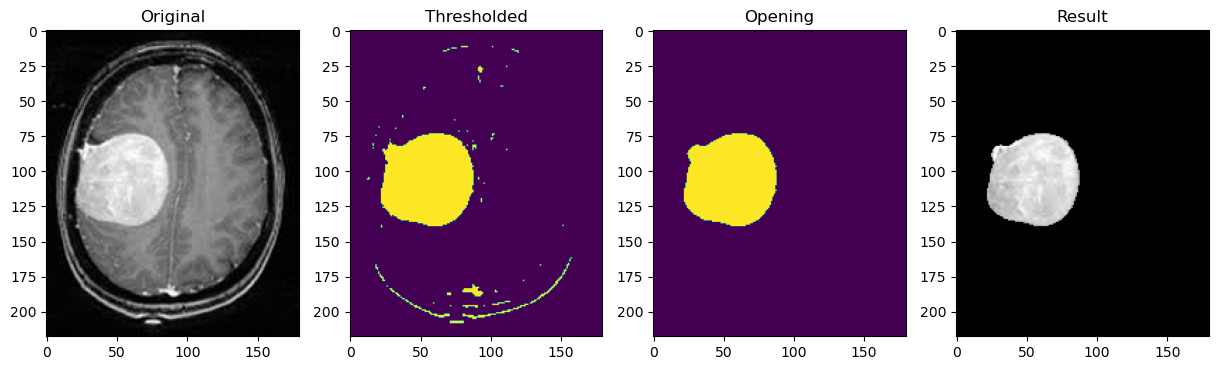

area of the tumor : 46.41975 cm2


In [107]:
# Manual threshold
h,bins = np.histogram(im.flatten(), bins=range(256))

t = manual_threshold(im, 155)
mask = opening(t[:,:,1], disk(5))

im_1 = im.copy()
im_1[mask==0] = 0


plt.figure()
plt.bar(bins[:-1],h,bins[1]-bins[0])
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(1,4,1)
plt.imshow(im)
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(t[:,:,1])
plt.title('Thresholded')
plt.subplot(1,4,3)
plt.imshow(opening(t[:,:,1],disk(4)))
plt.title('Opening')
plt.subplot(1,4,4)
plt.imshow(im_1)
plt.title('Result')
plt.show()

compute_tumor_size(im_1[:,:,1])



Optimal threshold 0: 75
Optimal threshold 1: 168


/tmp/ipykernel_589947/3212131292.py:40: RuntimeWarning: invalid value encountered in scalar divide
  m0 = (np.arange(0,t)*p[:t]).sum()/w0


area of the tumor : 44.528575000000004 cm2


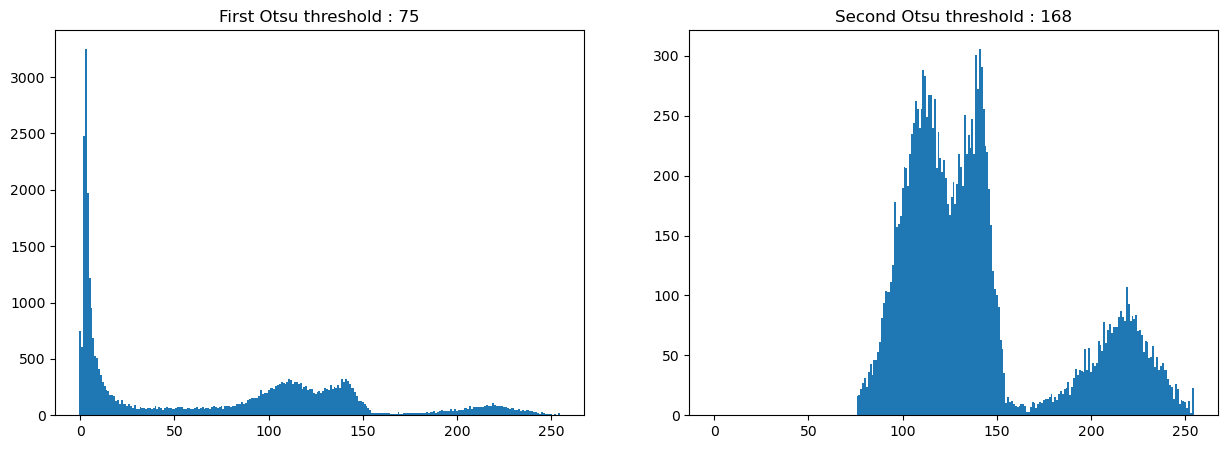

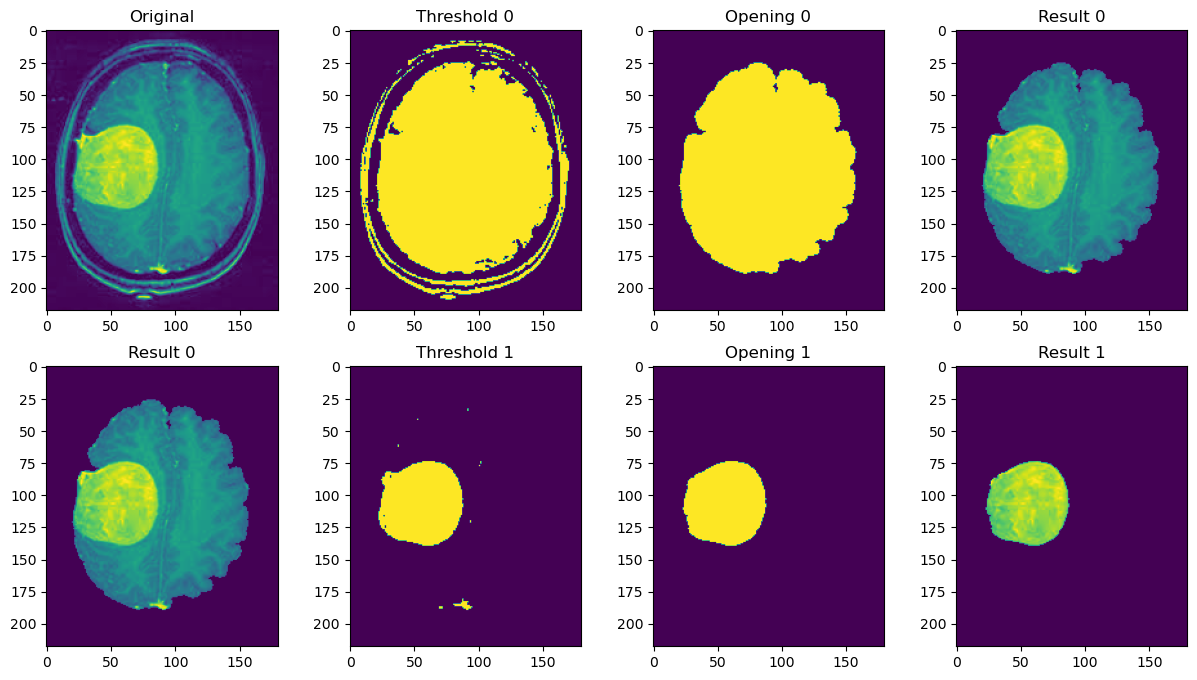

In [154]:
# Otsu threshold
im = imread('mri_brain.jpg')[:,:,0]

h0,bins0 = np.histogram(im.flatten(), bins=range(256))

t0,vw0,vb0,sep0 = otsu_threshold(h)
print("Optimal threshold 0: %d"%t0)
mask0 = opening(im>t0, disk(5))

im_2 = im.copy()
im_2[mask0==0] = 0

h1,bins1 = np.histogram(im_2.flatten(), bins=range(256))
h1[0] = 0

t1,vw1,vb1,sep1 = otsu_threshold(h1)
sep1[:100] = 0
t1 = np.argmax(sep1)
print("Optimal threshold 1: %d"%t1)
mask1 = opening(im_2>t1, disk(5))

im_3 = im.copy()
im_3[mask1 == 0] = 0

compute_tumor_size(im_3)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.bar(bins[:-1],h0,bins[1]-bins[0])
plt.title(f"First Otsu threshold : {t0}")
plt.subplot(1,2,2)
plt.bar(bins[:-1],h1,bins[1]-bins[0])
plt.title(f"Second Otsu threshold : {t1}")
plt.show()

plt.figure(figsize=(15,8))
plt.subplot(2,4,1)
plt.imshow(im)
plt.title('Original')
plt.subplot(2,4,2)
plt.imshow(im>t0)
plt.title('Threshold 0')
plt.subplot(2,4,3)
plt.imshow(mask0)
plt.title('Opening 0')
plt.subplot(2,4,4)
plt.imshow(im_2)
plt.title('Result 0')
plt.subplot(2,4,5)
plt.imshow(im_2)
plt.title('Result 0')
plt.subplot(2,4,6)
plt.imshow(im_2>t1)
plt.title('Threshold 1')
plt.subplot(2,4,7)
plt.imshow(mask1)
plt.title('Opening 1')
plt.subplot(2,4,8)
plt.imshow(im_3)
plt.title('Result 1')
plt.show()



Optimal threshold 0: 75
area of the tumor : 45.5998 cm2


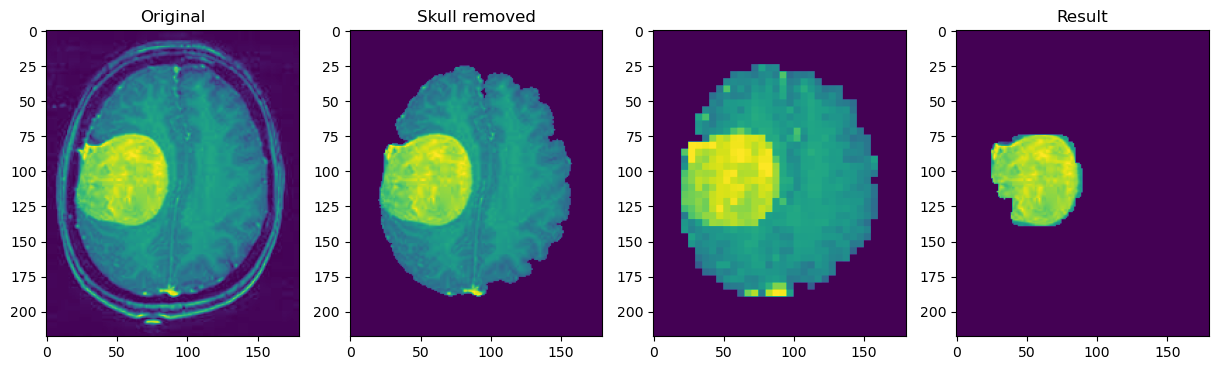

In [157]:
# Region descriptor

# We first need to remove the skull, let's use the otsu threshold as done above
im = imread('mri_brain.jpg')[:,:,0]

h0,bins0 = np.histogram(im.flatten(), bins=range(256))
t0,vw0,vb0,sep0 = otsu_threshold(h)
print("Optimal threshold 0: %d"%t0)
mask0 = opening(im>t0, disk(5))
im_2 = im.copy()
im_2[mask0==0] = 0


def texture_descriptor(N):
    e = N.max()
    return e

def sliding_window(im, PATCH_SIZE):
    output = np.zeros((im.shape[0], im.shape[1]))
    for i in range(0, im.shape[0]-PATCH_SIZE[0]+1, PATCH_SIZE[0]):
        for j in range(0, im.shape[1]-PATCH_SIZE[1]+1, PATCH_SIZE[1]):
            patch = im[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]]
            output[i:i+PATCH_SIZE[0], j:j+PATCH_SIZE[1]] = texture_descriptor(patch)
    return output

size=5

output = sliding_window(im_2, (size,size))

threshold = manual_threshold(output, 200)
mask = opening(threshold, disk(5))

compute_tumor_size(mask)

plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(im)
plt.title('Original')
plt.subplot(1,4,2)
plt.imshow(im_2)
plt.title('Skull removed')
plt.subplot(1,4,3)
plt.imshow(output)
plt.subplot(1,4,4)
plt.imshow(im*mask)
plt.title('Result')
plt.show()


(218, 180)
46.2875
area of the tumor : 46.2875 cm2
None


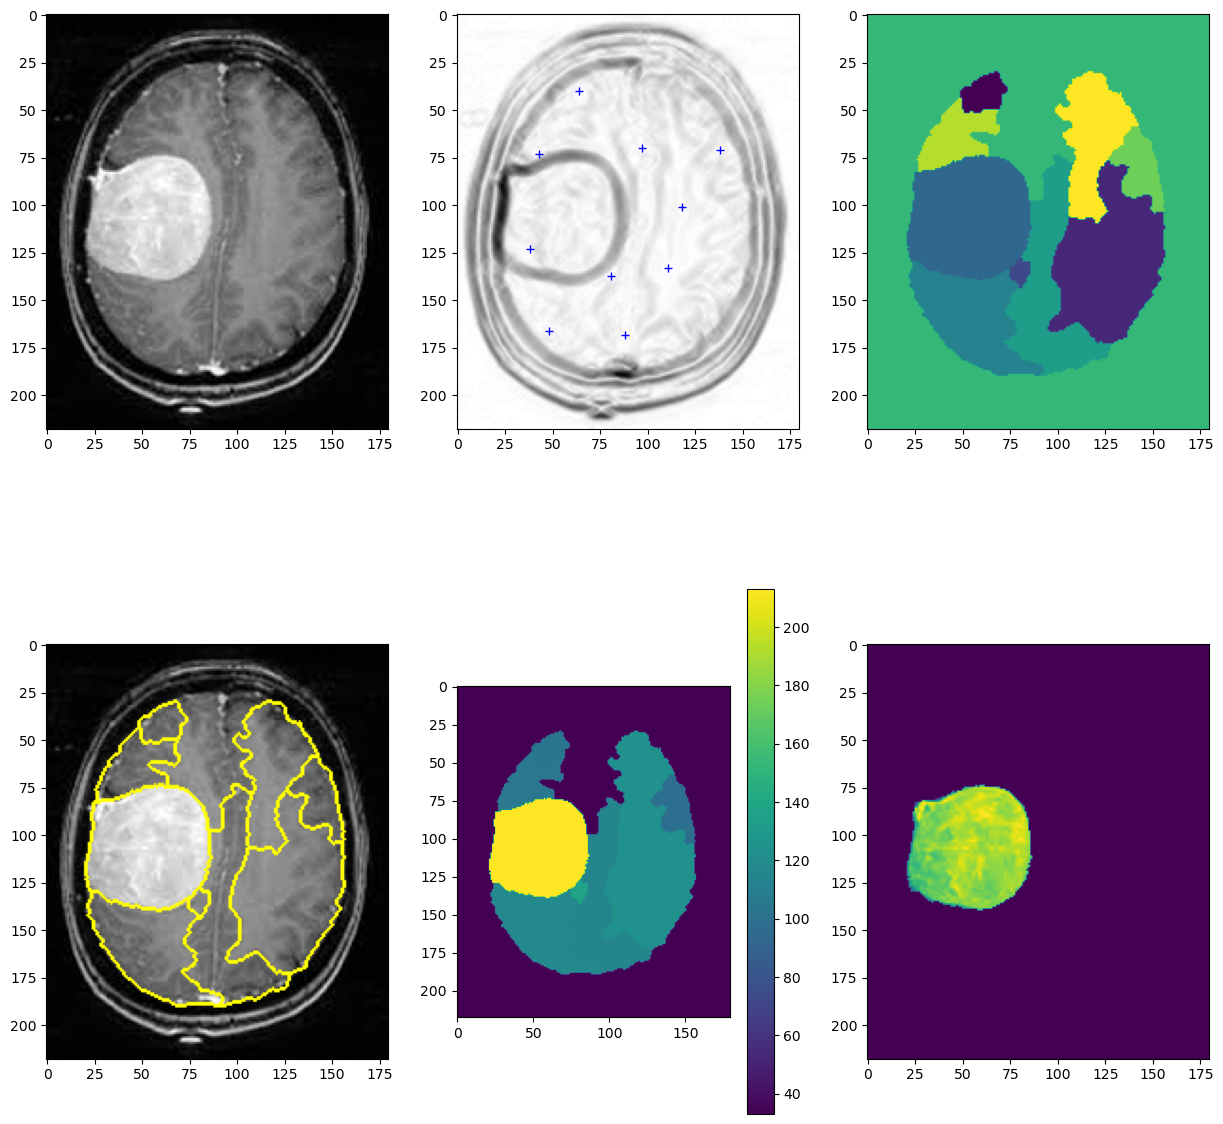

In [171]:
# Watershed
# We first need to remove the skull, let's use the otsu threshold as done above
im = imread('mri_brain.jpg')[:,:,0]

h0,_ = np.histogram(im.flatten(), bins=range(256))
t0,_,_,_ = otsu_threshold(h)
mask0 = opening(im>t0, disk(5))
im_2 = im.copy()
im_2[mask0==0] = 0

# Compute the gradient of the image:
gradient = skr.gradient(skr.mean(im, disk(smoothing_factor)), disk(1))
markers_coordinates = peak_local_max(gradient.max()-gradient,threshold_rel=0.1, min_distance=30)

markers = np.zeros_like(im)
for i,(row,col) in enumerate(markers_coordinates):
    markers[row,col] = i+1

ws = watershed(gradient, markers)

# Reduce possible oversampling (using mosaic)
def get_descriptor(region):
    return region.mean()

descriptors = np.zeros(ws.max()+1)
im_descriptors = np.zeros_like(im)
print(im_descriptors.shape)

for i in range(ws.min(),ws.max()+1):
    descriptors[i] = get_descriptor(im[ws==i])
    im_descriptors[ws==i] = descriptors[i]

mask = im_descriptors>150

# Retrieve the tumor as a region prop
lab = label(mask)  # label of mask, only the tumor left
props = regionprops(lab)

# Compute tumor size
print(props[0].area*(0.115**2))
print(compute_tumor_size(im*mask))

plt.figure(figsize=[15,15])
plt.subplot(2,3,1)
plt.imshow(im,cmap=plt.cm.gray)
plt.subplot(2,3,2)
for marker in markers_coordinates:
    plt.plot(marker[1],marker[0],'b+')
plt.imshow(gradient.max()-gradient,cmap=plt.cm.gray)
plt.subplot(2,3,3)
plt.imshow(ws)
plt.subplot(2,3,4)
plt.imshow(mark_boundaries(im,ws))
plt.subplot(2,3,5)
plt.imshow(im_descriptors)
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow(im*mask)
plt.show()

